In [ ]:
import shutil
import os

def clear_folder(folder_path):
    if os.path.exists(folder_path):
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f'Failed to delete {file_path}. Reason: {e}')
        print(f"All contents of the folder '{folder_path}' have been deleted successfully.")
    else:
        print(f"The folder '{folder_path}' does not exist.")

folder_path = '/content/frames'
clear_folder(folder_path)

The folder '/content/frames' has been deleted successfully.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_path = '/content/drive/MyDrive/dogs_dataset/is_dog.pt' #YOLO Model
output_folder = '/content/dog_npy/' #For testing --ignore
frames_folder = '/content/frames/' #Just a temporary folder

#Better to use GDrive
root_folder = "/content/drive/MyDrive/dogs_dataset" #Dataset root path
new_root_folder = "/content/drive/MyDrive/train_dataset" #Storage of npy

batch_size = 12 #For LSTM Sequence
IMAGE_SIZE = (224, 224)
SEQUENCE_LENGTH = 12  # Number of frames per sequence
NUM_CLASSES = 5

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.0/757.0 kB 7.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
from ultralytics import YOLO
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

model = YOLO(model_path)

In [ ]:
def extract_frames(video_path, frames_folder):
    os.makedirs(frames_folder, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    success = True

    # Extract the video base name without extension
    video_basename = os.path.splitext(os.path.basename(video_path))[0]

    while success:
        success, frame = cap.read()
        if success:
            frame_filename = os.path.join(frames_folder, f'frame_{frame_count:04d}.jpg')
            cv2.imwrite(frame_filename, frame)
            frame_count += 1

    cap.release()
    return frame_count

def detect_dog(img_path, output_folder, dog_frames, show=False):
    if img_path is not None:
        image = Image.open(img_path).convert('RGB')
        image_np = np.array(image)
        results = model(image_np, conf=0.25)
        os.makedirs(output_folder, exist_ok=True)
        detected_objects = results[0].boxes
        dog_count = 0

        for box in detected_objects:
            if box.cls == 0:  # Adjust this if 'dog' has a different class id
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                cropped_image = image.crop((x1, y1, x2, y2))
                width, height = cropped_image.size
                max_dim = max(width, height)
                pad_left = (max_dim - width) // 2
                pad_top = (max_dim - height) // 2
                pad_right = max_dim - width - pad_left
                pad_bottom = max_dim - height - pad_top

                padded_image = ImageOps.expand(cropped_image, (pad_left, pad_top, pad_right, pad_bottom), fill=(0, 0, 0))
                resized_image = padded_image.resize((224, 224))

                dog_frames.append(np.array(resized_image))

                if show:
                  plt.imshow(resized_image)
                  plt.axis('off')
                  plt.show()

        dog_count = len(dog_frames)

        return dog_count

def frame_to_npy(video_path, frames_folder, output_folder, num_frames, show=False):
      dog_frames = []
      image_basename = os.path.splitext(os.path.basename(video_path))[0]

      for frame_number in range(num_frames):
          frame_path = os.path.join(frames_folder, f'frame_{frame_number:04d}.jpg')
          dog_num = detect_dog(frame_path, output_folder, dog_frames, show)

      np.save(os.path.join(output_folder, f'{image_basename}.npy'), np.array(dog_frames))

def batch_data(data, batch_size):
    """
    Batch the data based on the given batch size.

    Parameters:
    - data: numpy array, the data to be batched
    - batch_size: int, the size of each batch

    Returns:
    - batched_data: list of numpy arrays, where each array is a batch
    """
    num_samples = len(data)
    num_batches = num_samples // batch_size
    batched_data = []

    for i in range(num_batches):
        batch_start = i * batch_size
        batch_end = (i + 1) * batch_size
        batch = data[batch_start:batch_end]
        batched_data.append(batch)

    return np.array(batched_data)


In [ ]:
'''#Get frame of a video
num_frames = extract_frames(video_path, frames_folder)
print(f"Extracted {num_frames} frames from the video.")
#Save to npy
frame_to_npy(video_path, frames_folder, output_folder, num_frames)
data = np.load('/content/dog_npy/Pitbull_barking_#shorts(360p).npy')
#Batch it for lstm
batch_size = 10
batched_data = batch_data(data, batch_size)
print("Number of batches:", len(batched_data))
print("Shape of first batch:", batched_data[0].shape)'''

'#Get frame of a video\nnum_frames = extract_frames(video_path, frames_folder)\nprint(f"Extracted {num_frames} frames from the video.")\n#Save to npy\nframe_to_npy(video_path, frames_folder, output_folder, num_frames)\ndata = np.load(\'/content/dog_npy/Pitbull_barking_#shorts(360p).npy\')\n#Batch it for lstm\nbatch_size = 10\nbatched_data = batch_data(data, batch_size)\nprint("Number of batches:", len(batched_data))\nprint("Shape of first batch:", batched_data[0].shape)'

In [ ]:
def process_class_folder(class_folder, output_folder, batch_size):
    # Iterate over videos in class folder
    for video_file in os.listdir(class_folder):
        if video_file.endswith(".mp4"):
            video_path = os.path.join(class_folder, video_file)
            frames_folder = '/content/frames/'
            os.makedirs(frames_folder, exist_ok=True)
            num_frames = extract_frames(video_path, frames_folder)
            frame_to_npy(video_path, frames_folder, output_folder, num_frames)
            # Load processed data
            data = np.load(os.path.join(output_folder, f'{os.path.splitext(video_file)[0]}.npy'))
            # Batch data
            batched_data = batch_data(data, batch_size)
            # Save batched data
            np.save(os.path.join(output_folder, f'{os.path.splitext(video_file)[0]}_batched.npy'), batched_data)

def process_all_class_folders(root_folder, new_root_folder, batch_size):
    # Iterate over class folders
    for class_name in os.listdir(root_folder):
        class_folder = os.path.join(root_folder, class_name)
        if os.path.isdir(class_folder):
            output_class_folder = os.path.join(new_root_folder, class_name)
            os.makedirs(output_class_folder, exist_ok=True)
            process_class_folder(class_folder, output_class_folder, batch_size)

In [ ]:
process_all_class_folders(root_folder, new_root_folder, batch_size)

Streaming output truncated to the last 5000 lines.
0: 384x640 2 0s, 8.7ms
Speed: 1.8ms preprocess, 8.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 0s, 8.9ms
Speed: 1.7ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 0, 8.9ms
Speed: 1.7ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 0, 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 0, 10.8ms
Speed: 1.7ms preprocess, 10.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 0s, 8.9ms
Speed: 2.1ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 0s, 10.0ms
Speed: 2.0ms preprocess, 10.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 0s, 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 1.4ms postprocess per image at shape (1, 3,

In [ ]:
def load_npy_files(root_folder):
    npy_data = {}

    for class_name in os.listdir(root_folder):
        class_folder = os.path.join(root_folder, class_name)
        if os.path.isdir(class_folder):
            npy_data[class_name] = []
            for npy_file in os.listdir(class_folder):
                if npy_file.endswith(".npy"):
                    npy_path = os.path.join(class_folder, npy_file)
                    data = np.load(npy_path)
                    npy_data[class_name].append(data)
                    print(f"Loaded '{npy_file}' with shape: {data.shape}")

    return npy_data

npy_data = load_npy_files(root_folder)

#Loading for Training

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
def load_data(root_folder, label_encoder):
    X = []
    y = []
    class_dict = {}

    for idx, class_name in enumerate(os.listdir(root_folder)):
        class_folder = os.path.join(root_folder, class_name)
        if os.path.isdir(class_folder):
            class_dict[idx] = class_name
            for npy_file in os.listdir(class_folder):
                if npy_file.endswith(".npy"):
                    npy_path = os.path.join(class_folder, npy_file)
                    data = np.load(npy_path)
                    if data.shape[1:] == (12, 224, 224, 3):
                        X.extend(data)
                        y.extend([idx] * len(data))
                    else:
                        print(f"Skipping '{npy_file}' due to incorrect shape: {data.shape}")

    y_encoded = label_encoder.fit_transform(y)
    class_labels = {idx: class_name for idx, class_name in enumerate(label_encoder.classes_)}

    return np.array(X), y_encoded, class_dict, class_labels

label_encoder = LabelEncoder()

X, y_encoded, class_dict, class_labels = load_data(new_root_folder, label_encoder)

# Print the class dictionary
print("Class dictionary:")
print(class_dict)

# Print the class labels dictionary
print("Class labels dictionary:")
print(class_labels)


Skipping 'VID_20240501130111.npy' due to incorrect shape: (130, 224, 224, 3)
Skipping 'Cutest Shih Tzu walk - 3 months old Mimi.npy' due to incorrect shape: (312, 224, 224, 3)
Skipping 'VID_20240501130837.npy' due to incorrect shape: (98, 224, 224, 3)
Skipping 'vlc-record-2024-05-18-12h52m00s-Train your dog to COME to you NO MATTER WHAT.mp4-.npy' due to incorrect shape: (203, 224, 224, 3)
Skipping 'VID_20240501130158.npy' due to incorrect shape: (100, 224, 224, 3)
Skipping 'vlc-record-2024-05-18-13h08m15s-The DOWN Command - Robert Cabral Dog Training #15.mp4-.npy' due to incorrect shape: (180, 224, 224, 3)
Skipping 'vlc-record-2024-05-18-13h22m03s-Teach Your Dog To Go To Bed And RELAX - Professional Dog Training Tips.mp4-.npy' due to incorrect shape: (212, 224, 224, 3)
Skipping 'vlc-record-2024-05-18-13h20m47s-Teach Your Dog To Go To Bed And RELAX - Professional Dog Training Tips.mp4-.npy' due to incorrect shape: (49, 224, 224, 3)
Skipping 'vlc-record-2024-05-18-12h42m44s-Puppy Trainin

In [ ]:
from keras.utils import to_categorical
y_one_hot = to_categorical(y_encoded)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.3, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (447, 12, 224, 224, 3) (447, 5)
Testing set shape: (192, 12, 224, 224, 3) (192, 5)


# Training LSTM

## Stacked LSTM

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Input, TimeDistributed, Flatten, LSTM, BatchNormalization, Dropout, Dense, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
base_model.trainable = False

# Define LSTM model
inputs = Input(shape=(SEQUENCE_LENGTH,) + IMAGE_SIZE + (3,))
x = TimeDistributed(base_model)(inputs)
x = TimeDistributed(Flatten())(x)
x = LSTM(512, return_sequences=True)(x)  # First LSTM layer with return_sequences=True
x = LSTM(256, return_sequences=False)(x)  # Second LSTM layer with return_sequences=False
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)
stack_model = Model(inputs, outputs)
opt = Adam(learning_rate=0.0001)

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

stack_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
checkpoint_path = root_folder+'/best_stackmodel.h5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.0000000001)

# Training
history_stack = stack_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/100
14/14 [==============================] - ETA: 0s - loss: 1.4993 - accuracy: 0.5078
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to /content/drive/MyDrive/dogs_dataset/best_stackmodel.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 119s 6s/step - loss: 1.4993 - accuracy: 0.5078 - val_loss: 1.4064 - val_accuracy: 0.3333 - lr: 1.0000e-04
Epoch 2/100
14/14 [==============================] - ETA: 0s - loss: 0.9585 - accuracy: 0.6667
Epoch 2: val_accuracy improved from 0.33333 to 0.43229, saving model to /content/drive/MyDrive/dogs_dataset/best_stackmodel.h5
14/14 [==============================] - 31s 2s/step - loss: 0.9585 - accuracy: 0.6667 - val_loss: 1.3721 - val_accuracy: 0.4323 - lr: 1.0000e-04
Epoch 3/100
14/14 [==============================] - ETA: 0s - loss: 0.6957 - accuracy: 0.7405
Epoch 3: val_accuracy improved from 0.43229 to 0.59896, saving model to /content/drive/MyDrive/dogs_dataset/best_stackmodel.h5
14/14 [==============================] - 34s 3s/step - loss: 0.6957 - accuracy: 0.7405 - val_loss: 1.2670 - val_accuracy: 0.5990 - lr: 1.0000e-04
Epoch 4/100
14/14 [==============================] - ETA: 0s - loss: 0.4596 - accuracy: 0.8456
Epoch 4: val_accuracy 

## Bidirectional LSTM

In [ ]:
from tensorflow.keras.layers import Bidirectional

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
base_model.trainable = False

# Define LSTM model
inputs = Input(shape=(SEQUENCE_LENGTH,) + IMAGE_SIZE + (3,))
x = TimeDistributed(base_model)(inputs)
x = TimeDistributed(Flatten())(x)
x = Bidirectional(LSTM(512, return_sequences=False))(x)  # Bidirectional LSTM layer
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)
bi_model = Model(inputs, outputs)
opt = Adam(learning_rate=0.0001)
bi_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# Define callbacks
checkpoint = ModelCheckpoint(root_folder+"/best_bimodel.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.0000000001)

# Training
history_bidirectional = bi_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/100
14/14 [==============================] - ETA: 0s - loss: 1.3213 - accuracy: 0.5168
Epoch 1: val_accuracy improved from -inf to 0.29688, saving model to /content/drive/MyDrive/dogs_dataset/best_bimodel.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 132s 7s/step - loss: 1.3213 - accuracy: 0.5168 - val_loss: 1.8538 - val_accuracy: 0.2969 - lr: 1.0000e-04
Epoch 2/100
14/14 [==============================] - ETA: 0s - loss: 0.8902 - accuracy: 0.7159
Epoch 2: val_accuracy improved from 0.29688 to 0.30729, saving model to /content/drive/MyDrive/dogs_dataset/best_bimodel.h5
14/14 [==============================] - 50s 4s/step - loss: 0.8902 - accuracy: 0.7159 - val_loss: 1.7812 - val_accuracy: 0.3073 - lr: 1.0000e-04
Epoch 3/100
14/14 [==============================] - ETA: 0s - loss: 0.8054 - accuracy: 0.7517
Epoch 3: val_accuracy improved from 0.30729 to 0.31771, saving model to /content/drive/MyDrive/dogs_dataset/best_bimodel.h5
14/14 [==============================] - 79s 6s/step - loss: 0.8054 - accuracy: 0.7517 - val_loss: 1.7137 - val_accuracy: 0.3177 - lr: 1.0000e-04
Epoch 4/100
14/14 [==============================] - ETA: 0s - loss: 0.7628 - accuracy: 0.8009
Epoch 4: val_accuracy improv

## Vanila LSTM

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Input, TimeDistributed, Flatten, LSTM, BatchNormalization, Dropout, Dense, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
base_model.trainable = False

# Define LSTM model
inputs = Input(shape=(SEQUENCE_LENGTH,) + IMAGE_SIZE + (3,))
x = TimeDistributed(base_model)(inputs)
x = TimeDistributed(Flatten())(x)  # Flatten the output of InceptionV3
x = LSTM(256, return_sequences=False)(x)  # Set return_sequences to False
x = BatchNormalization()(x)  # Batch normalization
x = Dropout(0.5)(x)  # Dropout
outputs = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs, outputs)
opt = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# Define callbacks
checkpoint = ModelCheckpoint(root_folder+"/best_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.0000000001)

# Training
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/100
14/14 [==============================] - ETA: 0s - loss: 1.6061 - accuracy: 0.4072
Epoch 1: val_accuracy improved from -inf to 0.09896, saving model to /content/drive/MyDrive/dogs_dataset/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 43s 3s/step - loss: 1.6061 - accuracy: 0.4072 - val_loss: 1.7257 - val_accuracy: 0.0990 - lr: 1.0000e-04
Epoch 2/100
14/14 [==============================] - ETA: 0s - loss: 1.2525 - accuracy: 0.5101
Epoch 2: val_accuracy improved from 0.09896 to 0.21354, saving model to /content/drive/MyDrive/dogs_dataset/best_model.h5
14/14 [==============================] - 40s 3s/step - loss: 1.2525 - accuracy: 0.5101 - val_loss: 1.5998 - val_accuracy: 0.2135 - lr: 1.0000e-04
Epoch 3/100
14/14 [==============================] - ETA: 0s - loss: 1.1918 - accuracy: 0.5347
Epoch 3: val_accuracy improved from 0.21354 to 0.38021, saving model to /content/drive/MyDrive/dogs_dataset/best_model.h5
14/14 [==============================] - 38s 3s/step - loss: 1.1918 - accuracy: 0.5347 - val_loss: 1.3953 - val_accuracy: 0.3802 - lr: 1.0000e-04
Epoch 4/100
14/14 [==============================] - ETA: 0s - loss: 1.1207 - accuracy: 0.5996
Epoch 4: val_accuracy improved fr

# Evaluation

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_training_history(history, main_title):
    plt.figure(figsize=(12, 6))

    # Plot model loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(main_title + ' - Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot model accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(main_title + ' - Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

def plot_confusion_matrix(X, y, model, label_encoder):
    y_pred = model.predict(X)
    y_true = label_encoder.inverse_transform(np.argmax(y, axis=1))
    y_pred = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))
    conf_matrix = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

def plot_roc_auc_curve(model, X, y_true):
    # Predict probabilities for each class
    y_prob = model.predict(X)
    y_true = label_encoder.inverse_transform(np.argmax(y_true, axis=1))
    y_prob = label_encoder.inverse_transform(np.argmax(y_prob, axis=1))

    # Compute ROC AUC score for each class
    auc_scores = []
    for i in range(len(label_encoder.classes_)):
        auc_score = roc_auc_score(y_true[:, i], y_prob[:, i])
        auc_scores.append(auc_score)

    # Plot ROC AUC curve for each class
    plt.figure(figsize=(8, 6))
    for i in range(len(label_encoder.classes_)):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_prob[:, i])
        plt.plot(fpr, tpr, label=label_encoder.classes_[i] + ' (AUC = {:.2f})'.format(auc_scores[i]))

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


from sklearn.preprocessing import label_binarize

def plot_roc_auc_curve(model, X, y_true, class_names, main_title='ROC Curve'):
    """
    Plots the ROC curve for multi-class classification and calculates the AUC score for each class.

    Parameters:
    - model: trained model used for predictions.
    - X: array-like, feature data.
    - y_true: array-like, true labels.
    - class_names: list, names of the classes.
    - main_title: str, title of the plot.

    Returns:
    - None
    """
    # Predict probabilities
    y_pred_prob = model.predict(X)

    # Binarize the true labels
    y_true_binarized = label_binarize(y_true, classes=range(len(class_names)))

    # Plot settings
    plt.figure(figsize=(12, 8))
    sns.set(style='whitegrid')

    # Plot ROC curve for each class
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_prob[:, i])
        roc_auc = roc_auc_score(y_true_binarized[:, i], y_pred_prob[:, i])

        plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(main_title)
    plt.legend(loc='lower right')

    plt.show()

## Stacked LSTM

### Loss accuracy plot

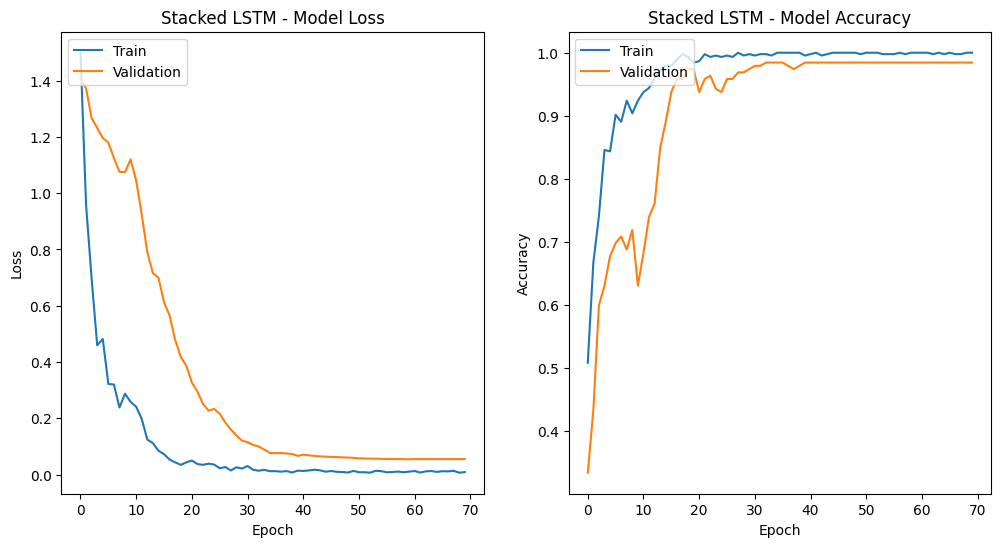

In [ ]:
plot_training_history(history_stack, 'Stacked LSTM')

### Confusion Matrix

In [ ]:
def plot_confusion_matrix(X, y, model, class_dict):
    """
    Plots the confusion matrix for the given model and data.

    Parameters:
    - X: array-like, feature data.
    - y: array-like, true labels (one-hot encoded).
    - model: trained model used for predictions.
    - class_dict: dictionary mapping class indices to class names.

    Returns:
    - None
    """
    y_pred = model.predict(X)
    y_true = np.argmax(y, axis=1)
    y_pred = np.argmax(y_pred, axis=1)

    # Map numeric labels to class names
    class_names = [class_dict[i] for i in range(len(class_dict))]

    conf_matrix = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
from tensorflow.keras.models import load_model
checkpoint_path = root_folder + '/best_stackmodel.h5'

# Load the model from the checkpoint
stack_model = load_model(checkpoint_path)

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

20/20 [==============================] - 14s 721ms/step


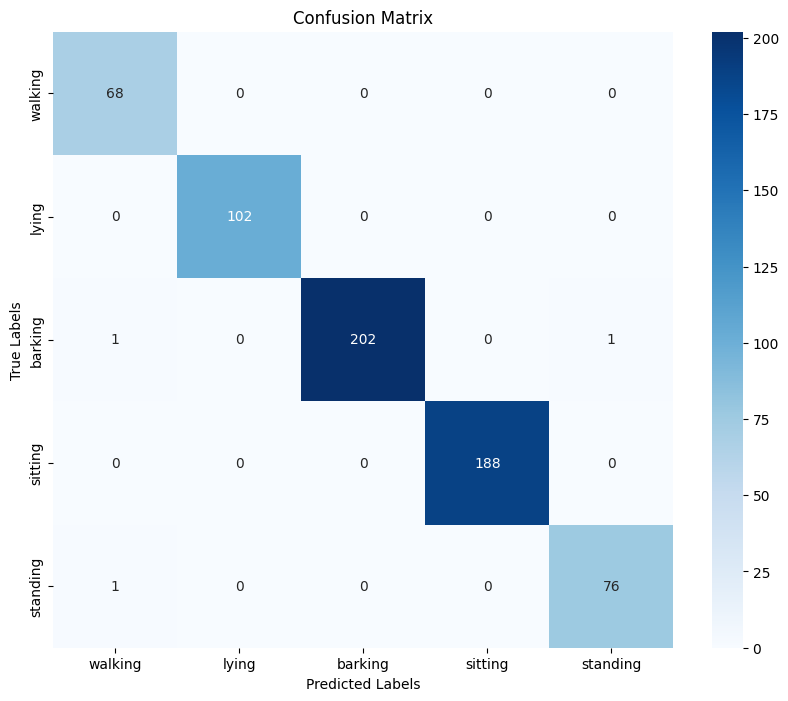

In [ ]:
plot_confusion_matrix(X, y_one_hot, stack_model, class_dict)

6/6 [==============================] - 4s 748ms/step


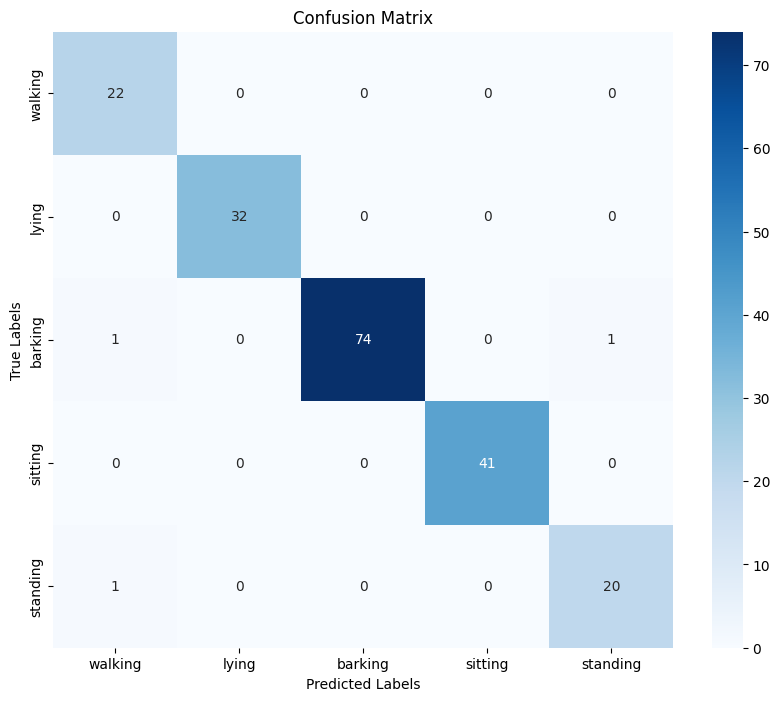

In [ ]:
plot_confusion_matrix(X_test, y_test, stack_model, class_dict)

20/20 [==============================] - 16s 648ms/step


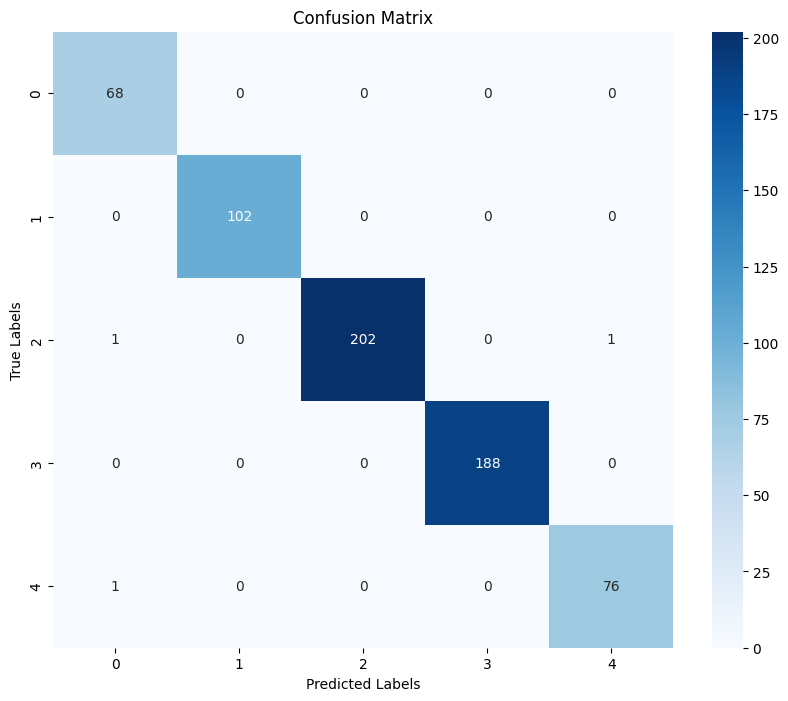

In [ ]:
plot_confusion_matrix(X, y_one_hot, stack_model, label_encoder)

6/6 [==============================] - 4s 695ms/step


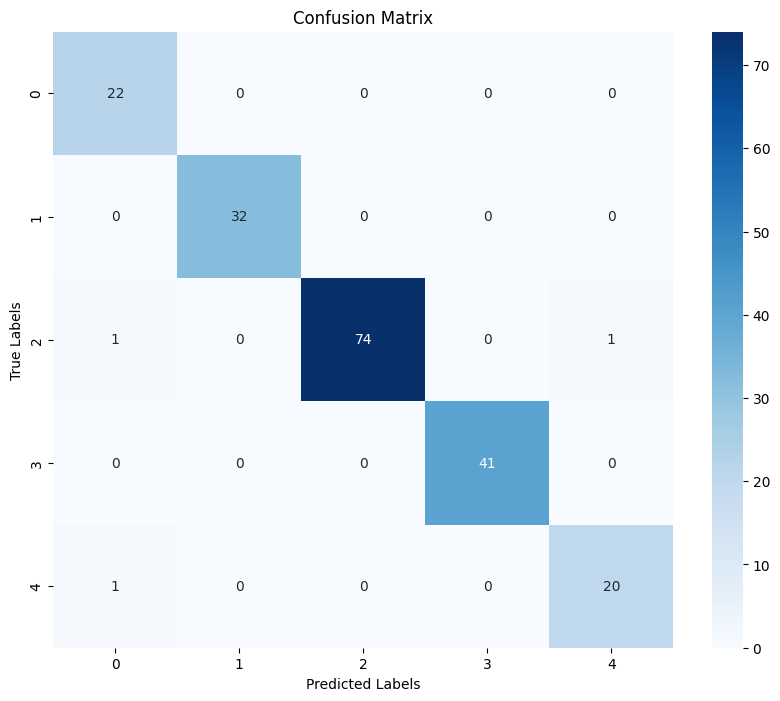

In [ ]:
plot_confusion_matrix(X_test, y_test, stack_model, label_encoder)

### ROC Curve

In [ ]:
def plot_roc_auc_curve(model, X, y, class_dict, title):
    """
    Plots the ROC AUC curve for the given model and data.

    Parameters:
    - model: trained model used for predictions.
    - X: array-like, feature data.
    - y: array-like, true labels (one-hot encoded).
    - class_dict: dictionary mapping class indices to class names.

    Returns:
    - None
    """
    y_pred = model.predict(X)
    n_classes = y.shape[1]

    # Compute ROC curve and ROC AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], y_pred[:, i])
        roc_auc[i] = roc_auc_score(y[:, i], y_pred[:, i])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {class_dict[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()


In [ ]:
class_names = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']

20/20 [==============================] - 14s 703ms/step


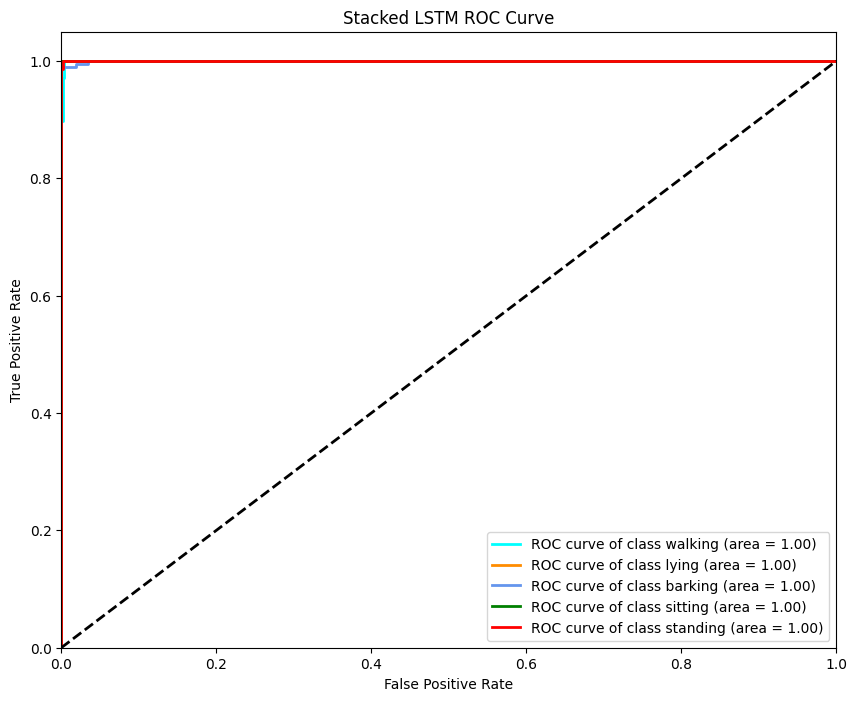

In [ ]:
plot_roc_auc_curve(stack_model, X, y_one_hot, class_dict, 'Stacked LSTM ROC Curve')

In [ ]:
from sklearn.metrics import classification_report
def display_classification_report(model, X, y_true, class_dict):
    """
    Displays the classification report for multi-class classification.

    Parameters:
    - model: trained model used for predictions.
    - X: array-like, feature data.
    - y_true: array-like, true labels (one-hot encoded).
    - class_dict: dictionary mapping class indices to class names.

    Returns:
    - None
    """
    # Predict class labels
    y_pred = model.predict(X)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_true, axis=1)

    # Generate classification report
    class_names = [class_dict[i] for i in range(len(class_dict))]
    report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)

    print("Classification Report:\n")
    print(report)


In [ ]:
display_classification_report(stack_model, X, y_one_hot, class_dict)

In [ ]:
display_classification_report(stack_model, X_test, y_test, class_dict)

6/6 [==============================] - 4s 769ms/step
Classification Report:

              precision    recall  f1-score   support

     walking       0.92      1.00      0.96        22
       lying       1.00      1.00      1.00        32
     barking       1.00      0.97      0.99        76
     sitting       1.00      1.00      1.00        41
    standing       0.95      0.95      0.95        21

    accuracy                           0.98       192
   macro avg       0.97      0.99      0.98       192
weighted avg       0.99      0.98      0.98       192



## Bidirectional LSTM

### Loss accuracy plot

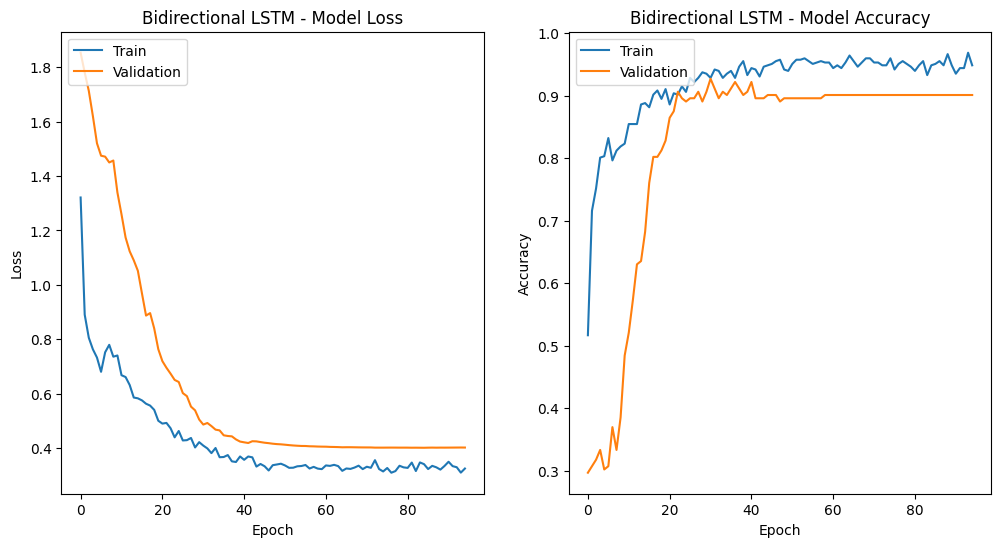

In [ ]:
plot_training_history(history_bidirectional, 'Bidirectional LSTM')

### Confusion Matrix

6/6 [==============================] - 4s 714ms/step


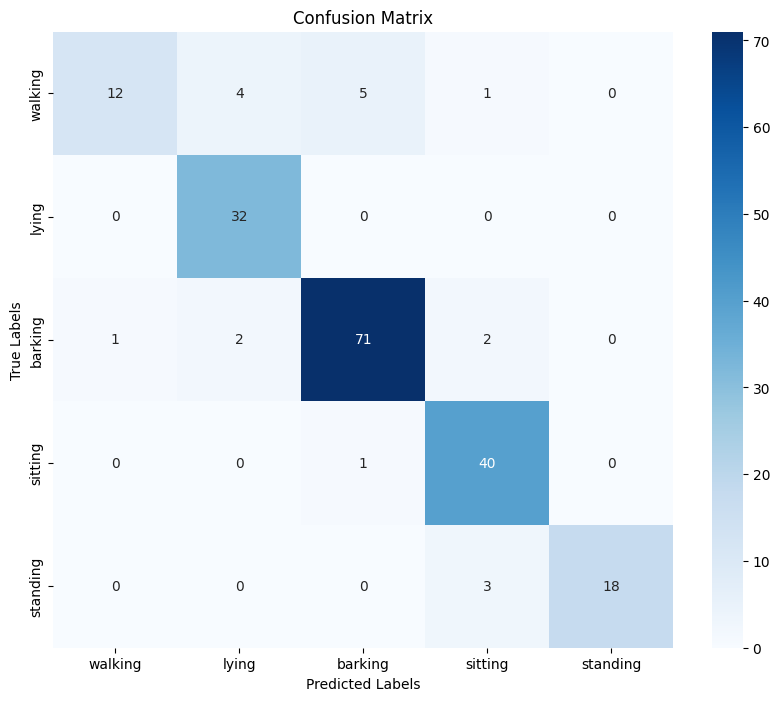

In [ ]:
plot_confusion_matrix(X_test, y_test, bi_model, class_dict)

### ROC Curve

6/6 [==============================] - 4s 724ms/step


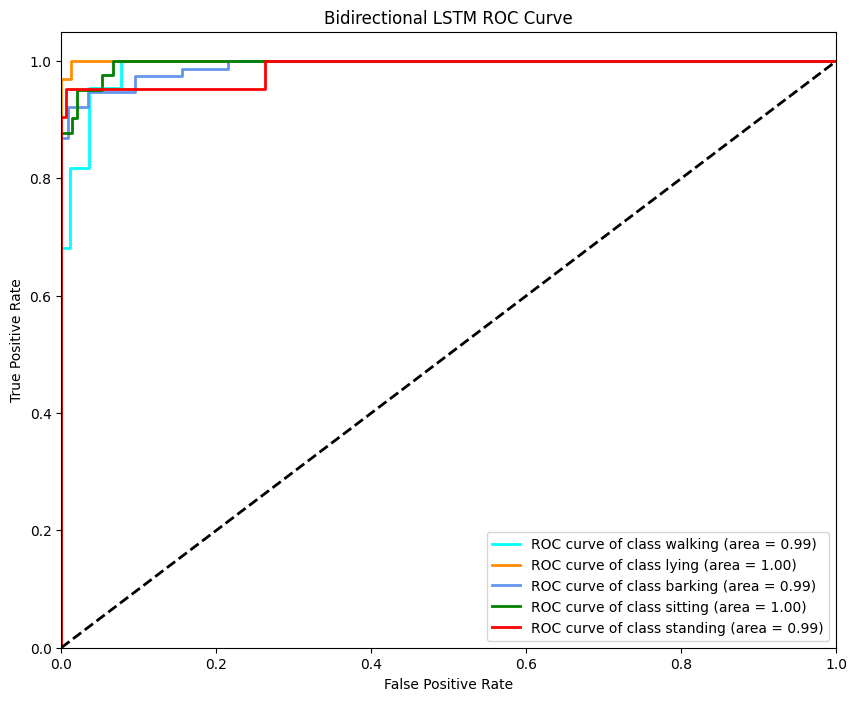

In [ ]:
plot_roc_auc_curve(bi_model, X_test, y_test, class_dict, 'Bidirectional LSTM ROC Curve')

In [ ]:
display_classification_report(bi_model, X_test, y_test, class_dict)

6/6 [==============================] - 4s 713ms/step
Classification Report:

              precision    recall  f1-score   support

     walking       0.92      0.55      0.69        22
       lying       0.84      1.00      0.91        32
     barking       0.92      0.93      0.93        76
     sitting       0.87      0.98      0.92        41
    standing       1.00      0.86      0.92        21

    accuracy                           0.90       192
   macro avg       0.91      0.86      0.87       192
weighted avg       0.91      0.90      0.90       192



## Vanila LSTM

### Loss accuracy plot

In [ ]:
plot_training_history(history, 'Vanila LSTM')

### Confusion Matrix

In [ ]:
plot_confusion_matrix(X, y_one_hot, model, label_encoder)

### ROC Curve

In [ ]:
plot_roc_auc_curve(model, X, y_one_hot, class_dict, 'Stacked LSTM ROC Curve')